In [1]:
import requests
from io import StringIO
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import datetime
import calendar
from sklearn.preprocessing import normalize
import time
import math
import cnn_feature_handler as fn
import feature_handler as handler
from keract import get_activations, display_activations

In [2]:
## read all data
path = "./Data/" 
TAIEX_df = pd.read_csv(path+'TXF.csv')
columns = ['Date','Open','High','Low','Close','Volume'] 
TAIEX_df.columns = columns
df = TAIEX_df[::-1].reset_index(drop=True)
price_df = df.drop(['Date', 'Volume'],axis=1)
day_list=[6,9,12]
for i in day_list:
    handler.MACD(TAIEX_df, i)
    handler.KD_indicator(TAIEX_df, i)

In [13]:
def get_CNN_cluster(cnn_day, TAIEX_df, Triple_up , Triple_down, Triple_day , num_cluster, hasTurning_point) :
    day = cnn_day
    df = TAIEX_df[::-1].reset_index(drop=True)
    ret = fn.triple_barrier(TAIEX_df.Close, Triple_up ,Triple_down, Triple_day)
    
    if hasTurning_point : 
        turning_date = fn.get_turning_point(df ,TAIEX_df, day)        
        start = 0 
        long_list = []
        long_label = []
        hasTurningPoint= []

        for i in turning_date:
            if start == 0 :
                start = i[0]
                continue
            split_data = TAIEX_df[start+1 : i[0]+1].drop(['Date', 'Volume'],axis=1)[::-1].reset_index(drop = True)
            long_list.extend(fn.get_series_data(split_data , day , False))
            long_label.extend(ret.triple_barrier_signal[start+day : i[0]+1][::-1])   
            start = i[0]
        long_list = np.array(long_list)
    else :
        long_list = fn.get_series_data(price_df , day , False)
        long_label = ret.triple_barrier_signal[day-1:len(ret)]
        
    print(pd.Series(long_label).value_counts())
        
    ## CNN Training by split data
    model = fn.cnn_training(long_list,long_label , day , 0.5 , 50)

    ## 取得CNN 最後一層的output
    flatten_list = []

    ## Ini all data
    long_list = fn.get_series_data(price_df , day , False)
    long_label = ret.triple_barrier_signal[day-1:len(ret)]
    long_label = long_label[::-1].reset_index(drop=True)
    for periodData in long_list :
        keract_inputs = periodData.reshape(1 , long_list.shape[1], long_list.shape[2],1)
        activations = get_activations(model, keract_inputs)
        flatten_list.append(activations['Dense'])
    long_cluster_label = pd.Series(fn.get_cluster(flatten_list, num_cluster))
    print(long_cluster_label.value_counts())
    return long_cluster_label , long_label
    


In [14]:
long_cluster , long_label = get_CNN_cluster(40, TAIEX_df, 1.03, 0.97, 15, 4 , True)

TypeError: get_series_data() missing 1 required positional argument: 'isBias'

In [10]:
short_cluster, short_label = get_CNN_cluster(8, TAIEX_df, 1.01, 0.99, 5 , 6 , False, [], False)

 1    1275
-1    1073
 0     577
Name: triple_barrier_signal, dtype: int64
Epoch 1/50
46/46 [==============================] - 1s 6ms/step - loss: 1.0752 - accuracy: 0.4384 - val_loss: 1.0529 - val_accuracy: 0.4258
Epoch 2/50
46/46 [==============================] - 0s 4ms/step - loss: 1.0575 - accuracy: 0.4412 - val_loss: 1.0530 - val_accuracy: 0.4375
Epoch 3/50
46/46 [==============================] - 0s 4ms/step - loss: 1.0544 - accuracy: 0.4419 - val_loss: 1.0640 - val_accuracy: 0.4163
Epoch 4/50
46/46 [==============================] - 0s 4ms/step - loss: 1.0516 - accuracy: 0.4466 - val_loss: 1.0584 - val_accuracy: 0.4142
Epoch 5/50
46/46 [==============================] - 0s 5ms/step - loss: 1.0442 - accuracy: 0.4549 - val_loss: 1.0476 - val_accuracy: 0.4252
Epoch 6/50
46/46 [==============================] - 0s 3ms/step - loss: 1.0495 - accuracy: 0.4549 - val_loss: 1.0605 - val_accuracy: 0.4135
Epoch 7/50
46/46 [==============================] - 0s 4ms/step - loss: 1.0446 - accu

In [15]:
print (len(short_cluster), short_cluster.value_counts())
short_cluster = short_cluster[:len(long_cluster)]


2925 4    1133
1     539
5     347
3     330
2     315
0     261
dtype: int64


In [16]:
# read index

TAIEX_Index = pd.read_csv(path+'TXF_Index.csv')
X = TAIEX_Index[::-1].reset_index(drop=True)[:len(short_cluster)]
X

,date,6bias_overbought/oversold,12bias_overbought/oversold,24bias_overbought/oversold,72bias_overbought/oversold,ma5&ma10,ma10&ma20,ma20&ma60,ma60&ma120,MACD_label,label,KD_cross,KD_overbought_sold(80/20),over_3days,put_week_net,top_6_10
0,2021/11/30,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,2021/11/29,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2021/11/26,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0
3,2021/11/25,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0
4,2021/11/24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2888,2010/3/12,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1
2889,2010/3/11,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1
2890,2010/3/10,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1
2891,2010/3/9,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


In [17]:
Y = pd.DataFrame()
Y['long'] = long_label.reset_index(drop = True)
Y['short'] = short_label[:len(long_label)]

## training feature : train with all feature
- serveal index and time serises price data
---
## XGBoost

In [19]:
# adding cluster
X['long_cluster'] = long_cluster
X['short_cluster'] = short_cluster

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score, precision_score, recall_score
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn import metrics
from sklearn.metrics import accuracy_score

from sklearn import svm

In [30]:
label_ = ['long' , 'short']
predict_ = pd.DataFrame()
isFirst = True
for label in label_ :
    test_ratio = 0.3
    trainp = X [math.ceil(len(X)*test_ratio) :].reset_index(drop = True)
    testp = X [ : math.ceil(len(X)*test_ratio)]
    print("label : ", label )
    print("test date start form ", testp.date[0],"to", testp.date[len(testp)-1] )

    X_train = trainp.drop(['date'],axis = 1)
    y_train = Y[label][math.ceil(len(X)*test_ratio) :]

    X_test = testp.drop(['date'],axis = 1)
    y_test = Y[label] [ : math.ceil(len(X)*test_ratio)]

    #X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)
    #ros = RandomOverSampler(random_state = 40)

    #X_train, y_train = ros.fit_resample(X_train, y_train)

    xgbc = XGBClassifier( booster='gbtree', max_depth=5,                
                  n_estimators=200, n_jobs=4, nthread=-1, eval_metric='mlogloss',
                  random_state=27,  tree_method='exact',
                  validate_parameters=1, verbosity=None)
    
    xgbc.fit(X_train,y_train)
    y_test_pred = xgbc.predict(X_test)
    y_train_pred = xgbc.predict(X_train)
    precision, recall, f1, _ = score(y_test, y_test_pred)
    
    print ( "precision(-1, 0, 1):" ,precision )    
    print ( "recall score(-1, 0, 1):" ,recall )
    print('training score :' , accuracy_score(y_train, y_train_pred))
    print('testing score :' , accuracy_score(y_test, y_test_pred))
    
    if isFirst :
        predict_['date'] = trainp.date
        isFirst = False
    predict_[label] = y_train_pred

label :  long
test date start form  2021/11/30 to 2018/5/18


C:\Users\kevin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


precision(-1, 0, 1): [0.32679739 0.34482759 0.41968912]
recall score(-1, 0, 1): [0.20491803 0.66666667 0.22881356]
training score : 0.6651851851851852
testing score : 0.358294930875576
label :  short
test date start form  2021/11/30 to 2018/5/18


C:\Users\kevin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


precision(-1, 0, 1): [0.3622291  0.21428571 0.51193634]
recall score(-1, 0, 1): [0.38235294 0.26666667 0.45199063]
training score : 0.6088888888888889
testing score : 0.3986175115207373


In [31]:
xgb_train = y_test_pred

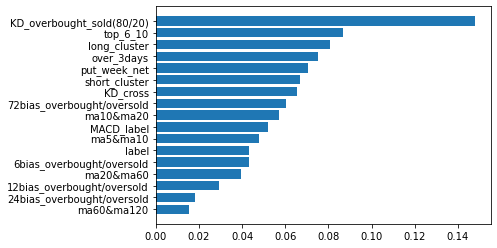

In [32]:
# feature important plot
from matplotlib import pyplot as plt
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()
    
f_importances(xgbc.feature_importances_, X_train.columns)

In [33]:
predict_.to_csv('XGBoost_train.csv',index=False, encoding='utf-8')

---
## SVM

In [34]:
label_ = ['long' , 'short']
cluster = [0,1,2]

predict_ = pd.DataFrame()
isFirst = True
for label in label_ :
    test_ratio = 0.3
    trainp = X [math.ceil(len(X)*test_ratio) :].reset_index(drop = True)
    testp = X [ : math.ceil(len(X)*test_ratio)]
    print("label : ", label )
    print("test date start form ", testp.date[0],"to", testp.date[len(testp)-1] )

    X_train = trainp.drop(['date'],axis = 1)
    y_train = Y[label][math.ceil(len(X)*test_ratio) :]

    X_test = testp.drop(['date'],axis = 1)
    y_test = Y[label] [ : math.ceil(len(X)*test_ratio)]

    #X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)
    #ros = RandomOverSampler(random_state = 40)

    #X_train, y_train = ros.fit_resample(X_train, y_train)

    clf=svm.SVC(kernel='rbf',C=1,gamma='auto')
    
    clf.fit(X_train,y_train)
    y_test_pred = clf.predict(X_test)
    y_train_pred = clf.predict(X_train)
    precision, recall, f1, _ = score(y_test, y_test_pred)
    print ( "precision(-1, 0, 1):" ,precision )
    print ( "recall score(-1, 0, 1):" ,recall )
    
    Y_train_pre = clf.predict(X_train)
    print('training score :' , accuracy_score(y_train, Y_train_pre))
    print('testing score :' , accuracy_score(y_test, y_test_pred))
    
    if isFirst :
        predict_['date'] = trainp.date
        isFirst = False
    predict_[label] = y_train_pred


label :  long
test date start form  2021/11/30 to 2018/5/18
precision(-1, 0, 1): [0.24137931 0.32478632 0.47111111]
recall score(-1, 0, 1): [0.05737705 0.7037037  0.29943503]
training score : 0.5180246913580246
testing score : 0.35714285714285715
label :  short
test date start form  2021/11/30 to 2018/5/18
precision(-1, 0, 1): [0.34782609 0.22485207 0.50995406]
recall score(-1, 0, 1): [0.05228758 0.28148148 0.77985948]
training score : 0.43555555555555553
testing score : 0.44585253456221197


In [35]:
for i in range(len(xgb_train)):
    if xgb_train[i] == y_test_pred[i] :
        continue
    else :
        xgb_train[i] = 0

In [36]:
precision, recall, f1, _ = score(y_test, xgb_train)
print ( "precision(-1, 0, 1):" ,precision )
print ( "recall score(-1, 0, 1):" ,recall )

precision(-1, 0, 1): [0.5        0.18250951 0.52160494]
recall score(-1, 0, 1): [0.02941176 0.71111111 0.39578454]


In [100]:
predict_.to_csv('Svm_train.csv',index=False, encoding='utf-8')

In [107]:
# feature important plot
from matplotlib import pyplot as plt
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()
    
f_importances(clf.coef_[2], X_train.columns)

AttributeError: coef_ is only available when using a linear kernel

## training feature : by each cluster
- serveal index and time serises price data
---
## XGBoost

In [26]:
label_ = ['long' , 'short']
cluster_ = [0,1,2,3]
predict_ = pd.DataFrame()
isFirst = True
for cluster in cluster_ :
    print ('cluster : ' , cluster)
    for label in label_ :
        test_ratio = 0.3
        trainp = X [math.ceil(len(X)*test_ratio) :].reset_index(drop = True)
        testp = X [ : math.ceil(len(X)*test_ratio)]
        print("label : ", label )
        print("test date start form ", testp.date[0],"to", testp.date[len(testp)-1] )

        X_train = trainp.drop(['date'],axis = 1).reset_index(drop = True)
        y_train = Y[label][math.ceil(len(X)*test_ratio) :].reset_index(drop = True)
        
        
        X_test = testp.drop(['date'],axis = 1).reset_index(drop = True)
        y_test = Y[label] [ : math.ceil(len(X)*test_ratio)].reset_index(drop = True)
        
        X_train_cluster = X_train[X_train.long_cluster==cluster]
        y_train_cluster = y_train[X_train.long_cluster==cluster]
        
        
        X_test_cluster =  X_test[X_test.long_cluster==cluster]
        y_test_cluster = y_test[X_test.long_cluster==cluster]

        #X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)
        #ros = RandomOverSampler(random_state = 40)

        #X_train, y_train = ros.fit_resample(X_train, y_train)

        xgbc = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
                      colsample_bynode=1, colsample_bytree=0.6, gamma=0.01, gpu_id=-1,
                      importance_type='gain',learning_rate=0.1, max_delta_step=0, max_depth=2,
                      min_child_weight=1, monotone_constraints='()',
                      n_estimators=200, n_jobs=4, nthread=-1, eval_metric='mlogloss',
                      random_state=27, reg_alpha=0, reg_lambda=1,
                      seed=27, subsample=1, tree_method='exact',
                      validate_parameters=1,  verbosity = 0)

        xgbc.fit(X_train_cluster,y_train_cluster)
        y_test_predp = xgbc.predict(X_test_cluster)

        precision, recall, f1, _ = score(y_test_cluster, y_test_predp)
        print ( "precision(-1, 0, 1):" ,precision )
        print ( "recall score(-1, 0, 1):" ,recall )
#         if isFirst :
#             predict_['date'] = testp.date
#             isFirst = False
#         predict_[label] = y_test_predp

cluster :  0
label :  long
test date start form  2021/11/30 to 2018/5/18


C:\Users\kevin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


precision(-1, 0, 1): [0.56521739 0.39622642 0.33333333]
recall score(-1, 0, 1): [0.21666667 0.80769231 0.05      ]
label :  short
test date start form  2021/11/30 to 2018/5/18


C:\Users\kevin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


precision(-1, 0, 1): [0.44444444 0.26086957 0.40625   ]
recall score(-1, 0, 1): [0.30769231 0.27272727 0.57777778]
cluster :  1
label :  long
test date start form  2021/11/30 to 2018/5/18
precision(-1, 0, 1): [0.41666667 0.29464286 0.46666667]
recall score(-1, 0, 1): [0.13761468 0.90825688 0.04142012]


C:\Users\kevin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


label :  short
test date start form  2021/11/30 to 2018/5/18
precision(-1, 0, 1): [0.37755102 0.20338983 0.51515152]
recall score(-1, 0, 1):

C:\Users\kevin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


 [0.5648855  0.17142857 0.3655914 ]
cluster :  2
label :  long
test date start form  2021/11/30 to 2018/5/18


C:\Users\kevin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


precision(-1, 0, 1): [0.26315789 0.33333333 0.44736842]
recall score(-1, 0, 1): [0.2        0.01785714 0.7816092 ]
label :  short
test date start form  2021/11/30 to 2018/5/18


C:\Users\kevin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


precision(-1, 0, 1): [0.375      0.         0.54814815]
recall score(-1, 0, 1): [0.29166667 0.         0.69158879]
cluster :  3
label :  long
test date start form  2021/11/30 to 2018/5/18


C:\Users\kevin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


precision(-1, 0, 1): [0.375      0.42222222 0.58      ]
recall score(-1, 0, 1): [0.24       0.71698113 0.37179487]
label :  short
test date start form  2021/11/30 to 2018/5/18


C:\Users\kevin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


precision(-1, 0, 1): [0.11111111 0.21276596 0.63013699]
recall score(-1, 0, 1): [0.10526316 0.34482759 0.51685393]


In [27]:
label_ = ['long' , 'short']
cluster_ = [0,1,2,3]
predict_ = pd.DataFrame()
isFirst = True
for cluster in cluster_ :
    print ('cluster : ' , cluster)
    for label in label_ :
        test_ratio = 0.4
        trainp = X [math.ceil(len(X)*test_ratio) :].reset_index(drop = True)
        testp = X [ : math.ceil(len(X)*test_ratio)]
        print("label : ", label )
        print("test date start form ", testp.date[0],"to", testp.date[len(testp)-1] )

        X_train = trainp.drop(['date'],axis = 1).reset_index(drop = True)
        y_train = Y[label][math.ceil(len(X)*test_ratio) :].reset_index(drop = True)
        
        
        X_test = testp.drop(['date'],axis = 1).reset_index(drop = True)
        y_test = Y[label] [ : math.ceil(len(X)*test_ratio)].reset_index(drop = True)
        
        X_train_cluster = X_train[X_train.long_cluster==cluster]
        y_train_cluster = y_train[X_train.long_cluster==cluster]
        
        
        X_test_cluster =  X_test[X_test.long_cluster==cluster]
        y_test_cluster = y_test[X_test.long_cluster==cluster]

        #X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)
        #ros = RandomOverSampler(random_state = 40)

        #X_train, y_train = ros.fit_resample(X_train, y_train)

        clf=svm.SVC(kernel='linear',C=2,gamma='auto')

        clf.fit(X_train_cluster,y_train_cluster)
        y_test_predp = clf.predict(X_test_cluster)

        precision, recall, f1, _ = score(y_test_cluster, y_test_predp)
        print ( "precision(-1, 0, 1):" ,precision )
        print ( "recall score(-1, 0, 1):" ,recall )

#         if isFirst :
#             predict_['date'] = testp.date
#             isFirst = False
#         predict_[label] = y_test_predp

cluster :  0
label :  long
test date start form  2021/11/30 to 2017/3/15
precision(-1, 0, 1): [0.         0.53719008 0.        ]
recall score(-1, 0, 1): [0. 1. 0.]
label :  short
test date start form  2021/11/30 to 2017/3/15
precision(-1, 0, 1): [0.37333333 0.5625     0.40740741]
recall score(-1, 0, 1): [0.30769231 0.31034483 0.59139785]
cluster :  1
label :  long
test date start form  2021/11/30 to 2017/3/15
precision(-1, 0, 1): [0.35714286 0.36703297 1.        ]
recall score(-1, 0, 1): [0.03846154 0.97660819 0.00591716]
label :  short
test date start form  2021/11/30 to 2017/3/15
precision(-1, 0, 1): [0.37007874 0.         0.49537037]
recall score(-1, 0, 1): [0.58024691 0.         0.5245098 ]
cluster :  2
label :  long
test date start form  2021/11/30 to 2017/3/15
precision(-1, 0, 1): [0.15625 0.      0.5    ]
recall score(-1, 0, 1): [0.2        0.         0.72268908]
label :  short
test date start form  2021/11/30 to 2017/3/15
precision(-1, 0, 1): [0.18181818 0.         0.5       ]


C:\Users\kevin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kevin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kevin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


day = 40
long_list = fn.get_series_data(price_df , day , False)
print(long_list.shape)

ret = fn.triple_barrier(TAIEX_df.Close, 1.04 ,0.97, 20)
long_label = ret.triple_barrier_signal[day-1:len(ret)]
print('count:' ,long_label.value_counts())
long_label = long_label[::-1].reset_index(drop=True)

## CNN Training by split data

model = fn.cnn_training(long_list,long_label , day , 0.5 , 50)

## 取得CNN 最後一層的output
flatten_list = []

## Ini all data
long_list = fn.get_series_data(price_df , day , False)
long_label = ret.triple_barrier_signal[day-1:len(ret)]
long_label = long_label[::-1].reset_index(drop=True)
for periodData in long_list :
    keract_inputs = periodData.reshape(1 , long_list.shape[1], long_list.shape[2],1)
    activations = get_activations(model, keract_inputs)
    flatten_list.append(activations['Dense'])

    day = 8
short_list = fn.get_series_data(price_df , day , True)
print(short_list.shape)

ret = fn.triple_barrier(TAIEX_df.Close, 1.01 ,0.99, 5)
short_label = ret.triple_barrier_signal[day-1:len(ret)]
print('count:' ,short_label.value_counts())
short_label = short_label[::-1].reset_index(drop=True)

## CNN Training
model = cnn_training(short_list,short_label , day , 0.5 , 50)

## 取得CNN 最後一層的output
flatten_list = []
for periodData in short_list :
    keract_inputs = periodData.reshape(1 , short_list.shape[1], short_list.shape[2],1)
    activations = get_activations(model, keract_inputs)
    flatten_list.append(activations['Dense'])

def get_cnn_series_data( df, period) -> list:
    list_ = []
    for i in range(len(df)-period+1):
        list_.append(df[i:i+period].values)
        
    return np.array(list_)

def cnn_training(allData, allLabel, day , splitsize, epoches = 100) :

    week_list = allData
    week_label = allLabel
    # 定義梯度下降批量
    batch_size = 32
    # 定義分類數量
    num_classes = 3
    # 定義訓練週期
    epochs = epoches

    # 定義圖像寬、高
    img_rows, img_cols = day, 17
    input_shape = ( img_rows, img_cols)

    # 載入 MNIST 訓練資料
    split_ratio = splitsize
    x_train = week_list[ math.ceil(len(week_list)*split_ratio) :]
    x_test = week_list[ : math.ceil(len(week_list)*split_ratio) ]

    y_train = week_label[ math.ceil(len(week_label)*split_ratio) :]
    y_test = week_label[ : math.ceil(len(week_label)*split_ratio) ]

    x_train = x_train.reshape(x_train.shape[0] , img_rows, img_cols,1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols ,1)

    # x_train  = torch.from_numpy(x_train)
    # x_test  = torch.from_numpy(x_test)

    # y_train = torch.from_numpy(y_train)
    # y_test = torch.from_numpy(y_test)

    input_shape = (img_rows, img_cols,1 )

    # 保留原始資料，供 cross tab function 使用
    y_test_org = y_test


    # y 值轉成 one-hot encoding
    y_train = np_utils.to_categorical(y_train, num_classes)
    y_test = np_utils.to_categorical(y_test, num_classes)

    # 建立簡單的線性執行的模型
    model = Sequential()
    # 建立卷積層，filter=32,即 output space 的深度, Kernal Size: 3x3, activation function 採用 relu
    model.add(Conv2D(16, kernel_size=(3,10),
                    activation='relu',
                    input_shape=input_shape))
    #model.add(BatchNormalization())
    model.add(GaussianNoise(0.5))
    # 建立卷積層，filter=64,即 output size, Kernal Size: 3x3, activation function 採用 relu
    model.add(Conv2D(32, (3,2), activation='relu'))
    # 建立池化層，池化大小=2x2，取最大值
    model.add(MaxPooling2D(pool_size=(3, 5)))
    # Dropout層隨機斷開輸入神經元，用於防止過度擬合，斷開比例:0.25
    model.add(Dropout(0.25))
    # Flatten層把多維的輸入一維化，常用在從卷積層到全連接層的過渡。
    model.add(Flatten( name ='flatten'))
    # 全連接層: 128個output
    model.add(Dense(batch_size, 'sigmoid', name ='Dense'))
    # 使用 softmax activation function，將結果分類
    model.add(Dense(num_classes, activation='softmax' ))

    # 編譯: 選擇損失函數、優化方法及成效衡量方式
    model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer='adam',
                metrics=['accuracy'])

    # 進行訓練, 訓練過程會存在 train_history 變數中
    train_history = model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(x_test, y_test))

    # 顯示損失函數、訓練成果(分數)
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score)
    print('Test accuracy:', score)
    return model

day = 10
X_cnn = get_cnn_series_data(X.drop(['date'],axis=1),day)

cnn_training(X_cnn , short_label[:len(X_cnn)], day , 0.3 , 100)


X_cnn.shape